In [1]:
from notebook_util import *
%matplotlib inline

In [2]:
from minee.data.mix_gaussian import MixedGaussian

- It is better to use `sample_size` instead of `n_sample`.
- Use the default `tensor` instead of `FloatTensor`. 

In [3]:
np.random.seed(0)
sample_size = 200
rho1 = 0.9
data = MixedGaussian(n_samples=sample_size,rho1=rho1).data
data_t = torch.Tensor(data)

Separate X data and Y data for the estimation. This should be a preprocessing done before instead of after feeding the data to the model.

In [4]:
X = data[:,[0]]
Y = data[:,[1]]

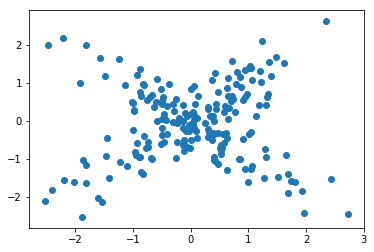

In [5]:
plt.scatter(X,Y)

Generate the reference samples by resampling.

In [6]:
X_ref = resample(X,batch_size=sample_size)
Y_ref = resample(Y,batch_size=sample_size)

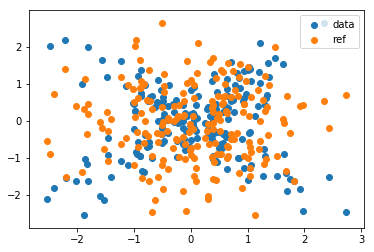

In [7]:
plt.scatter(X,Y,label="data")
plt.scatter(X_ref,Y_ref,label="ref")
plt.legend()

In [8]:
XY_t = torch.Tensor(np.concatenate((X,Y),axis=1))

In [9]:
XY_ref_t = torch.Tensor(np.concatenate((X_ref,Y_ref),axis=1))

In [10]:
batch_size = int(sample_size*0.5)
net_list = []
mi_lb_list = []
batch_mi_lb_list = []
batch_loss_list = []
ma_rate = 1
ma_ef = 1
lr = 1e-3
XY_net = Net(input_size=X.shape[1]+Y.shape[1])
optimizer = optim.Adam(XY_net.parameters(),lr=lr)

Automatically load previous results from db file if exists

In [11]:
fname = 'mix_gaussian_small_batch_no_ma.db'
if os.path.exists(fname):
    with open(fname,'rb') as f:
        net_list,mi_lb_list,batch_loss_list,batch_mi_lb_list,ma_ef = dill.load(f)
        XY_net.load_state_dict(net_list[-1])
        print('results loaded from '+fname)

Repeately run the following to continue to train

In [12]:
for j in range(50):
    for i in range(1000):
        optimizer.zero_grad()
        batch_XY = resample(XY_t,batch_size=batch_size)
        #batch_XY_ref = resample(XY_ref_t,batch_size=batch_size)
        batch_XY_ref = torch.Tensor(np.concatenate((resample(X,batch_size=batch_size), \
                                                    resample(Y,batch_size=batch_size)),axis=1))
        fXY = XY_net(batch_XY)
        efXY_ref = torch.exp(XY_net(batch_XY_ref))
        batch_mi_lb = torch.mean(fXY) - torch.log(torch.mean(efXY_ref))
        #loss = -batch_mi_lb
        ma_ef = (1-ma_rate)*ma_ef + ma_rate*torch.mean(efXY_ref)
        batch_loss = -(torch.mean(fXY) - (1/ma_ef.mean()).detach()*torch.mean(efXY_ref))
        batch_loss.backward()
        optimizer.step()    
        mi_lb_list = np.append(mi_lb_list, \
                                (torch.mean(XY_net(XY_t)) \
                                 - torch.log(torch.mean(torch.exp(XY_net(XY_ref_t))))).cpu().item())
        batch_mi_lb_list = np.append(batch_mi_lb_list,batch_mi_lb.cpu().item())
        batch_loss_list = np.append(batch_loss_list,batch_loss.cpu().item())
    net_list = np.append(net_list,XY_net.state_dict())
    # save existing work
    with open(str(j)+fname,'wb') as f:
        dill.dump([net_list,mi_lb_list,batch_loss_list,batch_mi_lb_list,ma_ef],f)
        print('results saved: '+str(j))

results saved: 0
results saved: 1
results saved: 2
results saved: 3
results saved: 4
results saved: 5
results saved: 6
results saved: 7
results saved: 8
results saved: 9
results saved: 10
results saved: 11
results saved: 12
results saved: 13
results saved: 14
results saved: 15
results saved: 16
results saved: 17
results saved: 18
results saved: 19
results saved: 20
results saved: 21
results saved: 22
results saved: 23
results saved: 24
results saved: 25
results saved: 26
results saved: 27
results saved: 28
results saved: 29
results saved: 30
results saved: 31
results saved: 32
results saved: 33
results saved: 34
results saved: 35
results saved: 36
results saved: 37
results saved: 38
results saved: 39
results saved: 40
results saved: 41
results saved: 42
results saved: 43
results saved: 44
results saved: 45
results saved: 46
results saved: 47
results saved: 48
results saved: 49


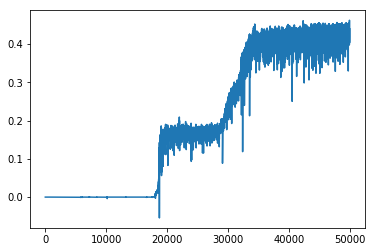

In [13]:
plt.plot(mi_lb_list)

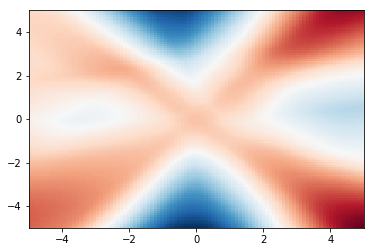

In [14]:
plot_net(XY_net)

To save new results to a db file using the following code, delete the existing db file.

In [15]:
if not os.path.exists(fname):
    with open(fname,'wb') as f:
        dill.dump([net_list,mi_lb_list,batch_loss_list,batch_mi_lb_list,ma_ef],f)
        print('results saved to '+fname)

results saved to mix_gaussian_small_batch_no_ma.db


-4.2557716369628904e-07

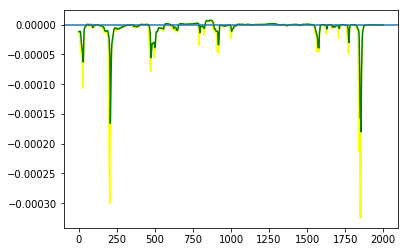

In [16]:
mi_max_envelope_estimate(mi_lb_list,2000,w1=10,w2=50)